# Classifying Rocks from Oil wells
### Neural Network implementation in pytorch

#### Declaration: 
My code uses the code provided in the labs as a building block.
The code for feature selection using genetic algorithm is taken from http://dkopczyk.quantee.co.uk/genetic-algorithm/ and it has been modified as per my needs

## Step 0: Download and import all required libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

## Step 1: Load and setup training dataset

The dataset consists of six files, with two data sets(train and test) from each well.

In [2]:
# load training data
data_train1 = pd.read_excel('oil-well/Oil_Reservoir_Data_1_train.xlsx')
data_train2 = pd.read_excel('oil-well/Oil_Reservoir_Data_2_train.xlsx')
data_train3 = pd.read_excel('oil-well/Oil_Reservoir_Data_3_train.xlsx')
# load testing data
data_test1 = pd.read_excel('oil-well/Oil_Reservoir_Data_1_test.xlsx')
data_test2 = pd.read_excel('oil-well/Oil_Reservoir_Data_2_test.xlsx')
data_test3 = pd.read_excel('oil-well/Oil_Reservoir_Data_3_test.xlsx')

# combining all training data
data_train=(data_train1.append(data_train2)).append(data_train3)

# combining all testing data
data_test=(data_test1.append(data_test2)).append(data_test3)

# Giving each class a numerical value
# Frac -> 0
# Good -> 1
# OK   -> 2

data_train.at[data_train['Unnamed: 10'] == 'Frac', ['Unnamed: 10']] = 0
data_train.at[data_train['Unnamed: 10'] == 'Good', ['Unnamed: 10']] = 1
data_train.at[data_train['Unnamed: 10'] == 'OK',   ['Unnamed: 10']] = 2

data_test.at[data_test['Unnamed: 10'] == 'Frac', ['Unnamed: 10']] = 0
data_test.at[data_test['Unnamed: 10'] == 'Good', ['Unnamed: 10']] = 1
data_test.at[data_test['Unnamed: 10'] == 'OK',   ['Unnamed: 10']] = 2

# making sure all values are numeric 
# combining traing and testing data 
data_train = data_train.apply(pd.to_numeric)
data_test = data_test.apply(pd.to_numeric)

data=data_train.append(data_test)
# Shuffling the data
data.sample(frac=1)


,GR,RDEV,RMEV,RXO,RHOB,NPHI,PEF,DT,Phi,logK,Unnamed: 10
8,0.542901,0.104482,0.121233,0.057150,0.788856,0.524590,0.280214,0.582567,0.153518,0.453238,0
63,0.386946,0.341179,0.395544,0.051820,0.165689,0.245219,0.088584,0.742091,0.580584,0.756539,1
34,0.515288,0.312784,0.308417,0.147440,0.389541,0.375000,0.123866,0.817779,0.370317,0.460151,1
51,0.308188,0.420208,0.413889,0.078556,0.569892,0.140027,1.000000,0.572113,0.337244,0.384956,2
8,0.654210,0.550304,0.638101,0.169737,0.570381,0.480874,0.042216,0.694297,0.085562,0.149023,1
17,0.356840,0.266421,0.329622,0.421270,0.470186,0.458333,0.132687,0.783563,0.510049,0.808137,0
4,0.497840,0.372218,0.405892,0.346561,0.528348,0.443306,0.096153,0.622313,0.086394,0.501980,0
41,0.292251,0.264126,0.242850,0.096045,0.294721,0.228825,0.121532,0.452124,0.520595,0.548198,2
40,0.596458,0.466835,0.530016,0.156854,0.540078,0.355191,0.125932,0.568029,0.136529,0.264986,2
72,0.337731,0.530871,0.449348,0.076298,0.279570,0.477459,0.254289,0.500842,0.592421,0.714907,1


2    104
1    104
0    104
Name: Unnamed: 10, dtype: int64
[104, 104, 104]
[0, 1, 2]


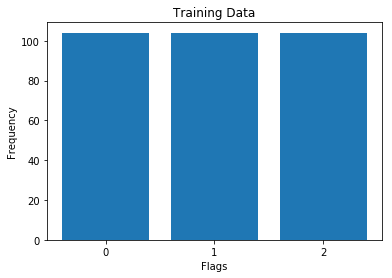

In [3]:
# Making sure we have equal distribution of all three classes
# Original Distribution was:
# 2    254
# 1    210
# 0    104


dfa = data[data['Unnamed: 10']==0]
dfb = data[data['Unnamed: 10']==1]
dfc = data[data['Unnamed: 10']==2]

dfasamplefive = dfa[:104]
dfbsamplefive = dfb[:104]
dfcsamplefive = dfc[:104]


data=(dfasamplefive.append(dfbsamplefive)).append(dfcsamplefive)

# extract frequency of each species class
class_freq = data['Unnamed: 10'].value_counts()
print(class_freq)
class_freq = list(class_freq.sort_index())
print(class_freq)
# x-axis labels and length
x_axis = list(range(0,3))
print(x_axis )
graph = plt.bar(x_axis, class_freq)
plt.xticks(x_axis)
plt.ylabel('Frequency')
plt.xlabel('Flags')
plt.title('Training Data')

plt.show()

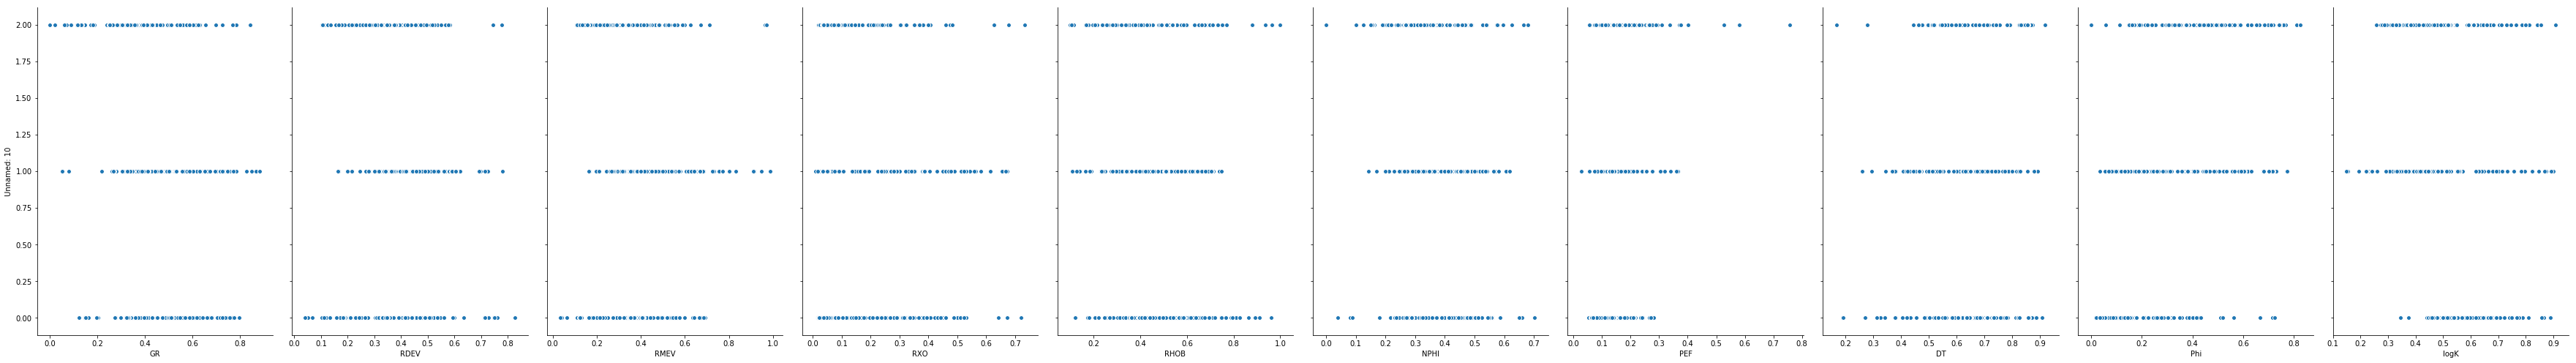

In [4]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=['GR', 'RDEV', 'RMEV', 'RXO', 'RHOB', 'NPHI', 'PEF', 'DT', 'Phi', 'logK'], y_vars='Unnamed: 10', size=7, aspect=0.7)

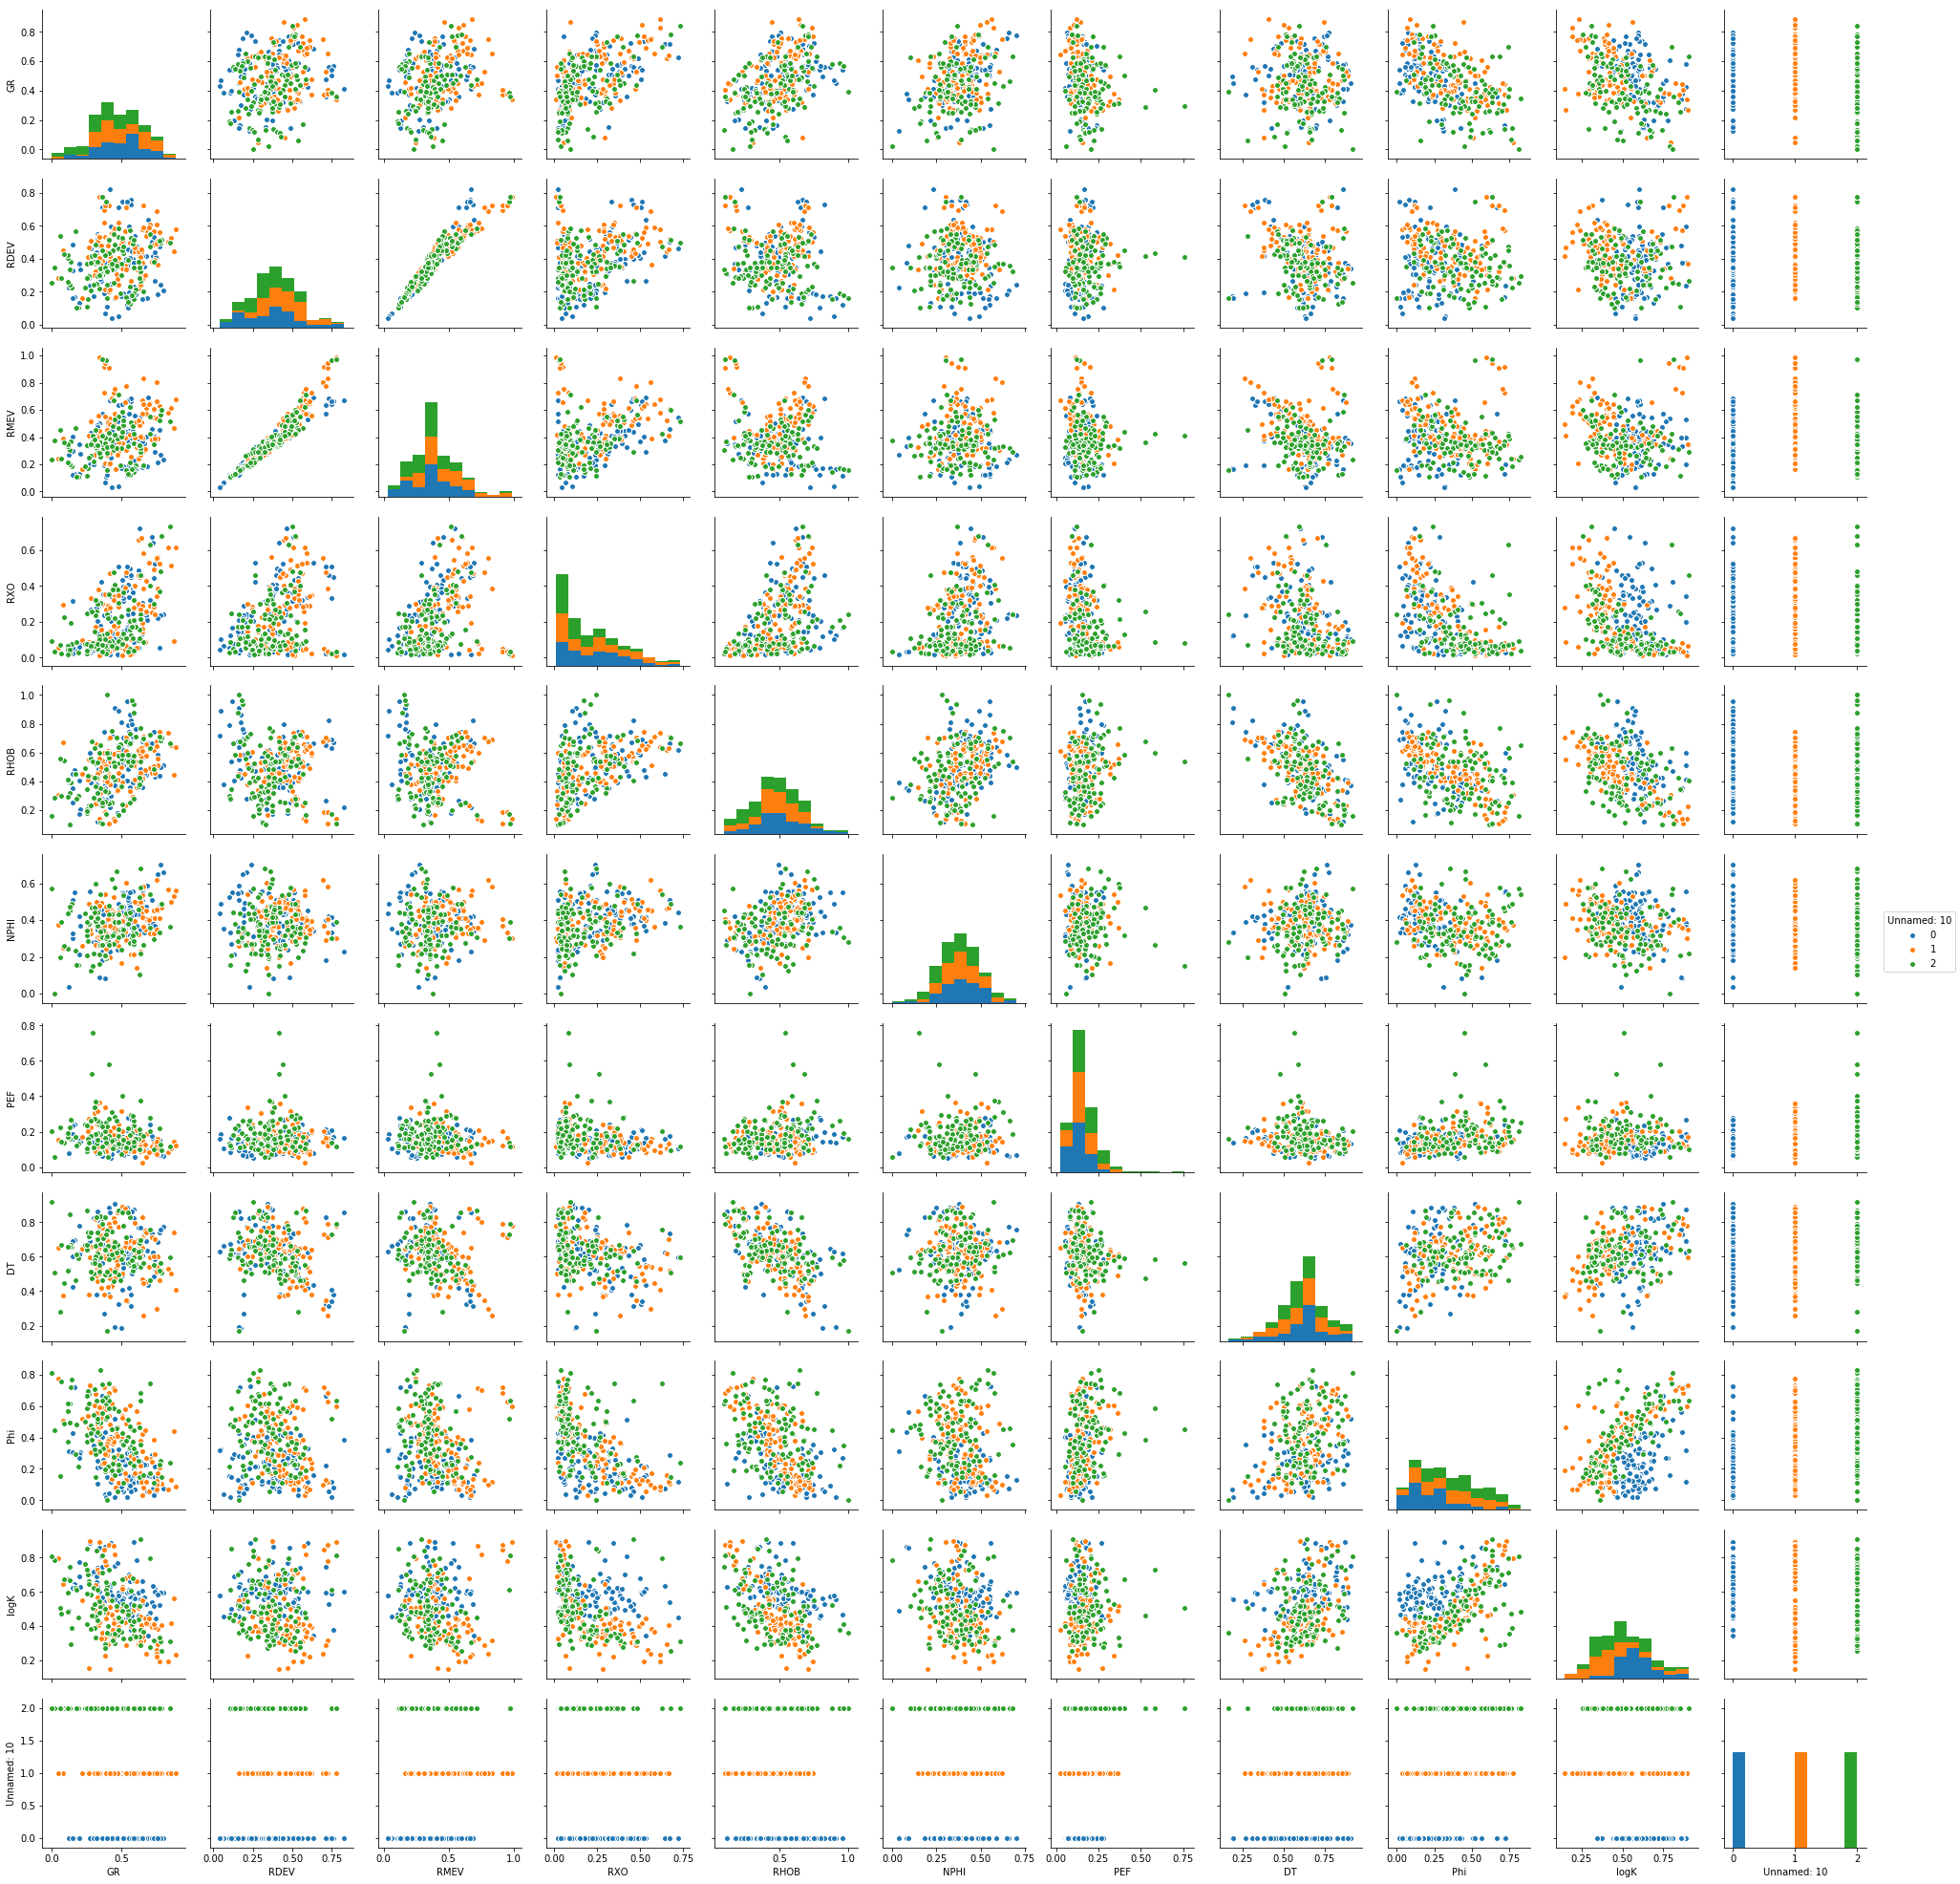

In [28]:
 sns.pairplot(data, hue="Unnamed: 10")

In [6]:
# Dropping columns based on feature selection
#features = ['GR', 'RDEV', 'RMEV', 'RXO', 'RHOB', 'NPHI', 'PEF', 'DT', 'Phi','logK']
           #[False  True    False   False   False  True    False  True  True  True]
           #[False  True   False    False   False  True    False False  True  True]
# data = data.drop(columns='GR')
# data = data.drop(columns='RDEV')
# data = data.drop(columns='RMEV')
# data = data.drop(columns='RXO')
# data = data.drop(columns='RHOB')
# data = data.drop(columns='NPHI')
# data = data.drop(columns='PEF')
# data = data.drop(columns='DT')


### Split data into input and target
The first 10 columns are features, the last one is target

In [7]:
msk = np.random.rand(len(data)) < 0.7
train_data = data[msk]
test_data = data[~msk]

n_features = train_data.shape[1]-1

In [8]:
# convert pandas dataframe to array
# the first 10 columns are features
# the last column is target
# split x (features) and y (targets)
train_input = train_data.iloc[:, :n_features]
train_target = train_data.iloc[:, n_features]

test_input = test_data.iloc[:, :n_features]
test_target = test_data.iloc[:, n_features]

### Feature Selection
I use differnet methods to see which features are contributing the most to determining the class.

[0.08737664 0.07754332 0.07847859 0.09452974 0.08734183 0.0697865
 0.08022475 0.07060375 0.15057773 0.20353716]


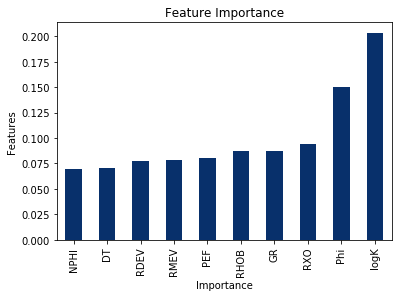

In [9]:
#Feature Importance

X = train_input  #independent columns
y = train_target    #target column i.e price range

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nsmallest(10).plot(kind='bar',colormap='Blues_r')
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [10]:
#Univariate Selection

X = train_input  #independent columns
y = train_target    #target column i.e price range

bestfeatures = SelectKBest(score_func=chi2, k=train_input.shape[1])
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

  Specs     Score
8   Phi  4.271164
2  RMEV  1.536793
9  logK  1.351002
3   RXO  1.301524
0    GR  0.953432
1  RDEV  0.937123
6   PEF  0.687265
4  RHOB  0.320797
5  NPHI  0.125684
7    DT  0.012946


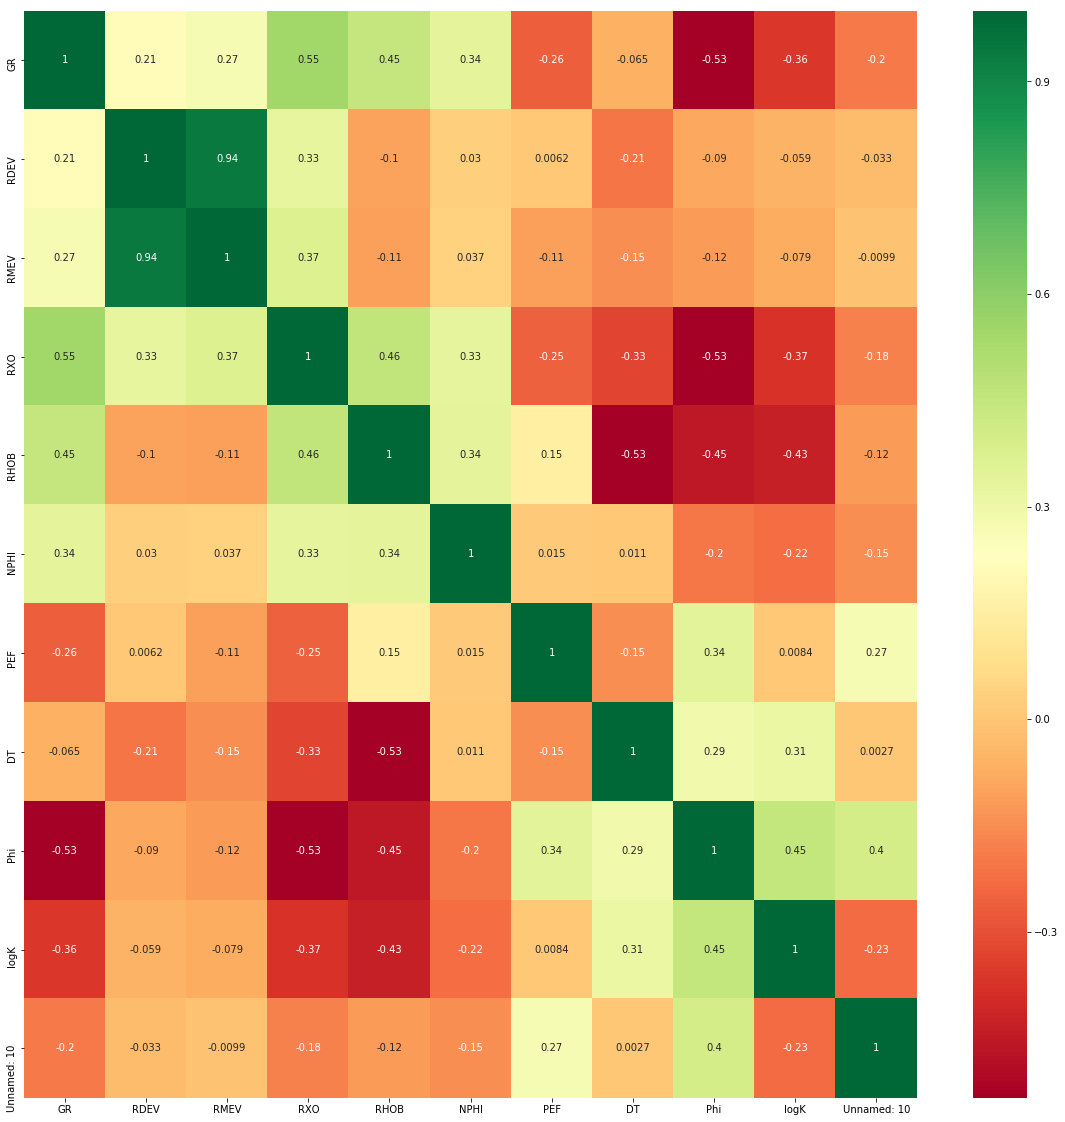

In [11]:
# Correlations
X = train_input  #independent columns
y = train_target    #target column i.e price range

#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Feature Selection using genetic algorithm
Source: http://dkopczyk.quantee.co.uk/genetic-algorithm/ 

[0.63043478 0.80434783 0.46666667 0.56818182 0.72727273]
CV MSE before feature selection: 0.64


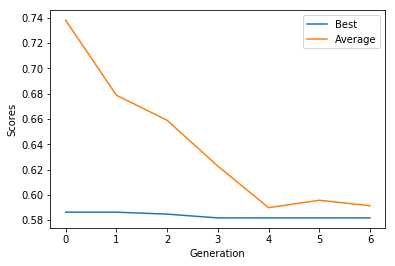

CV MSE after feature selection: 0.57
[False False False False False  True False False  True  True]
[0.45652174 0.84782609 0.55555556 0.45454545 0.54545455]


In [27]:
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

SEED = 2018
random.seed(SEED)
np.random.seed(SEED)

#==============================================================================
# Data 
#==============================================================================
# dataset = load_boston()
# X, y = dataset.data, dataset.target
# features = dataset.feature_names
X =train_input.values
y =train_target.values
features = ['GR', 'RDEV', 'RMEV', 'RXO', 'RHOB', 'NPHI', 'PEF', 'DT', 'Phi','logK']
#==============================================================================
# CV MSE before feature selection
#==============================================================================
# est = LinearRegression()
est = RidgeClassifier()
score = -1.0 * cross_val_score(est, X, y, cv=5, scoring="neg_mean_squared_error")
print(score)
print("CV MSE before feature selection: {:.2f}".format(np.mean(score)))

#==============================================================================
# Class performing feature selection with genetic algorithm
#==============================================================================
class GeneticSelector():
    def __init__(self, estimator, n_gen, size, n_best, n_rand, 
                 n_children, mutation_rate):
        # Estimator 
        self.estimator = estimator
        # Number of generations
        self.n_gen = n_gen
        # Number of chromosomes in population
        self.size = size
        # Number of best chromosomes to select
        self.n_best = n_best
        # Number of random chromosomes to select
        self.n_rand = n_rand
        # Number of children created during crossover
        self.n_children = n_children
        # Probablity of chromosome mutation
        self.mutation_rate = mutation_rate
        
        if int((self.n_best + self.n_rand) / 2) * self.n_children != self.size:
            raise ValueError("The population size is not stable.")  
            
    def initilize(self):
        population = []
        for i in range(self.size):
            chromosome = np.ones(self.n_features, dtype=np.bool)
            mask = np.random.rand(len(chromosome)) < 0.3
            chromosome[mask] = False
            population.append(chromosome)
        return population

    def fitness(self, population):
        X, y = self.dataset
        scores = []
        for chromosome in population:
            score = -1.0 * np.mean(cross_val_score(self.estimator, X[:,chromosome], y, 
                                                       cv=5, 
                                                       scoring="neg_mean_squared_error"))
            scores.append(score)
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds]), list(population[inds,:])

    def select(self, population_sorted):
        population_next = []
        for i in range(self.n_best):
            population_next.append(population_sorted[i])
        for i in range(self.n_rand):
            population_next.append(random.choice(population_sorted))
        random.shuffle(population_next)
        return population_next

    def crossover(self, population):
        population_next = []
        for i in range(int(len(population)/2)):
            for j in range(self.n_children):
                chromosome1, chromosome2 = population[i], population[len(population)-1-i]
                child = chromosome1
                mask = np.random.rand(len(child)) > 0.5
                child[mask] = chromosome2[mask]
                population_next.append(child)
        return population_next
	
    def mutate(self, population):
        population_next = []
        for i in range(len(population)):
            chromosome = population[i]
            if random.random() < self.mutation_rate:
                mask = np.random.rand(len(chromosome)) < 0.05
                chromosome[mask] = False
            population_next.append(chromosome)
        return population_next

    def generate(self, population):
        # Selection, crossover and mutation
        scores_sorted, population_sorted = self.fitness(population)
        population = self.select(population_sorted)
        population = self.crossover(population)
        population = self.mutate(population)
        # History
        self.chromosomes_best.append(population_sorted[0])
        self.scores_best.append(scores_sorted[0])
        self.scores_avg.append(np.mean(scores_sorted))
        
        return population

    def fit(self, X, y):
 
        self.chromosomes_best = []
        self.scores_best, self.scores_avg  = [], []
        
        self.dataset = X, y
        self.n_features = X.shape[1]
        
        population = self.initilize()
        for i in range(self.n_gen):
            population = self.generate(population)
            
        return self 
    
    @property
    def support_(self):
        return self.chromosomes_best[-1]

    def plot_scores(self):
        plt.plot(self.scores_best, label='Best')
        plt.plot(self.scores_avg, label='Average')
        plt.legend()
        plt.ylabel('Scores')
        plt.xlabel('Generation')
        plt.show()

sel = GeneticSelector(estimator=LinearRegression(), 
                      n_gen=7, size=200, n_best=40, n_rand=40, 
                      n_children=5, mutation_rate=0.05)
sel.fit(X, y)
sel.plot_scores()

score = -1.0 * cross_val_score(est, X[:,sel.support_], y, cv=5, scoring="neg_mean_squared_error")

print("CV MSE after feature selection: {:.2f}".format(np.mean(score)))
#features = ['GR', 'RDEV', 'RMEV', 'RXO', 'RHOB', 'NPHI', 'PEF', 'DT', 'Phi','logK']          
           #[False  True   False    False   False  True    False False  True  True]
print(sel.support_)
print(score)

### Using Other classification methods to compare with

1. KNeighborsClassifier 
2. DecisionTreeClassifier
3. RidgeClassifier

In [13]:
# KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(train_input,train_target) 
rslt = clf.predict(test_input)
#print(rslt)
scores = cross_val_score(clf, train_input,train_target, cv=5)
print(scores)
print('Accuracy score: %.2f %%'% (accuracy_score(test_target, rslt)*100))

[0.5        0.58695652 0.6        0.56818182 0.54545455]
Accuracy score: 60.92 %


In [14]:
# DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(train_input,train_target) 
scores = cross_val_score(clf, train_input,train_target, cv=10)
print(scores)
rslt = clf.predict(test_input)
#print(rslt)

print('Accuracy score: %.2f %%'% (accuracy_score(test_target, rslt)*100))

[0.60869565 0.56521739 0.56521739 0.47826087 0.65217391 0.69565217
 0.52173913 0.59090909 0.61904762 0.66666667]
Accuracy score: 67.82 %


In [15]:
# RidgeClassifier


clf = RidgeClassifier()
clf.fit(train_input,train_target) 
scores = cross_val_score(clf, train_input,train_target, cv=10)
print(scores)
rslt = clf.predict(test_input)
#print(rslt)

print('Accuracy score: %.2f %%'% (accuracy_score(test_target, rslt)*100))

[0.56521739 0.69565217 0.60869565 0.60869565 0.82608696 0.60869565
 0.39130435 0.45454545 0.38095238 0.66666667]
Accuracy score: 67.82 %


## Step 2: Define and train a neural network

I build a two neural networks:
- One hidden layer
        hidden_neurons=9
- Two hidden layer
        hidden_neurons1=9
        hidden_neurons2=6
- Three hidden layer
        hidden_neurons1=9
        hidden_neurons2=7
        hidden_neurons3=5
- Four hidden layer
        hidden_neurons1=9
        hidden_neurons2=7
        hidden_neurons3=5
        hidden_neurons4=3
        
Uncomment the one that you want to use. 

The network will be trained with Adamax as an optimiser, that will hold the current state and will update the parameters based on the computed gradients.

Its performance will be evaluated using cross-entropy.

In [16]:
# create Tensors to hold inputs and outputs. Tensors are data structures
# similar to numpy matrices. They can be operated on efficiently by a GPU

X = torch.Tensor(train_input.values).float()
Y = torch.Tensor(train_target.values).long()

In [17]:
# defining the number of inputs, classes, training epochs, and learning rate

input_neurons = n_features
output_neurons = 3
learning_rate = 0.01
num_epochs = 5000


In [18]:
# ONE Hidden Layer
hidden_neurons1=6
class OneLayerNet(torch.nn.Module):

    def __init__(self, n_input, n_hidden, n_output):
        super(OneLayerNet, self).__init__()
        # define linear hidden layer output
        self.hidden = torch.nn.Linear(n_input, n_hidden)
        # define linear output layer output
        self.out = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        """
            In the forward function we define the process of performing
            forward pass, that is to accept a Variable of input
            data, x, and return a Variable of output data, y_pred.
        """
        
        out = self.hidden(x)
#         m = nn.Threshold(-55, 5)
        m = nn.LeakyReLU(0.1)
        out = m(out)

#         out = torch.relu(out)
        out = self.out(out)

        return out

In [19]:
# TWO Hidden Layer
hidden_neurons1 = 9
hidden_neurons2 = 6
class TwoLayerNet(torch.nn.Module):

    def __init__(self, n_input, n_hidden1, n_output):
        super(TwoLayerNet, self).__init__()
        
        self.hidden1 = torch.nn.Linear(n_input, n_hidden1)
        self.hidden2 = torch.nn.Linear( n_hidden1, hidden_neurons2)
        
        self.out = torch.nn.Linear(hidden_neurons2, n_output)

    def forward(self, x):
        """
            In the forward function we define the process of performing
            forward pass, that is to accept a Variable of input
            data, x, and return a Variable of output data, y_pred.
        """
        out = self.hidden1(x)
        out = torch.relu(out)
        out = self.hidden2(out)
        out = torch.relu(out)
        y_pred = self.out(out)

        return y_pred

In [20]:
# THREE Hidden Layer
hidden_neurons1 = 9
hidden_neurons2 = 7
hidden_neurons3 = 5
class ThreeLayerNet(torch.nn.Module):

    def __init__(self, n_input, n_hidden1, n_output):
        super(ThreeLayerNet, self).__init__()
        
        self.hidden1 = torch.nn.Linear(n_input, n_hidden1)
        self.hidden2 = torch.nn.Linear( n_hidden1, hidden_neurons2)
        self.hidden3 = torch.nn.Linear( hidden_neurons2, hidden_neurons3)
        
        self.out = torch.nn.Linear(hidden_neurons3, n_output)

    def forward(self, x):
        """
            In the forward function we define the process of performing
            forward pass, that is to accept a Variable of input
            data, x, and return a Variable of output data, y_pred.
        """
        out = self.hidden1(x)
#         out= nn.LeakyReLU(0.1)
        
        out = torch.relu(out)
        out = self.hidden2(out)
#         out= nn.LeakyReLU(out)
        out = torch.relu(out)
        out = self.hidden3(out)
#         out= nn.LeakyReLU(out)
        out = torch.relu(out)
        y_pred = self.out(out)

        return y_pred

In [21]:
# FOUR Hidden Layer
hidden_neurons1 = 9
hidden_neurons2 = 8
hidden_neurons3 = 7
hidden_neurons4 = 5
class FourLayerNet(torch.nn.Module):

    def __init__(self, n_input, n_hidden1, n_output):
        super(FourLayerNet, self).__init__()
        
        self.hidden1 = torch.nn.Linear(n_input, n_hidden1)
        self.hidden2 = torch.nn.Linear( n_hidden1, hidden_neurons2)
        self.hidden3 = torch.nn.Linear( hidden_neurons2, hidden_neurons3)
        self.hidden4 = torch.nn.Linear( hidden_neurons3, hidden_neurons4)
        
        self.out = torch.nn.Linear(hidden_neurons4, n_output)

    def forward(self, x):
        """
            In the forward function we define the process of performing
            forward pass, that is to accept a Variable of input
            data, x, and return a Variable of output data, y_pred.
        """
        out = self.hidden1(x)
        out = torch.relu(out)
        out = self.hidden2(out)
        out = torch.relu(out)
        out = self.hidden3(out)
        out = torch.relu(out)
        out = self.hidden4(out)
        out = torch.relu(out)
        y_pred = self.out(out)

        return y_pred

In [22]:
# Selecting the network to use
# net = OneLayerNet(input_neurons, hidden_neurons1, output_neurons)
net = TwoLayerNet(input_neurons, hidden_neurons1, output_neurons)
# net = ThreeLayerNet(input_neurons, hidden_neurons1, output_neurons)
# net = FourLayerNet(input_neurons, hidden_neurons1, output_neurons)
# define loss function
loss_func = torch.nn.CrossEntropyLoss()

# define optimiser
optimiser = torch.optim.Adamax(net.parameters(), lr=learning_rate)

# store all losses for visualisation
all_losses = []

In [23]:
# train a neural network
for epoch in range(num_epochs):
    # Perform forward pass: compute predicted y by passing x to the model.
    Y_pred = net(X)

    # Compute loss
    loss = loss_func(Y_pred, Y)
    all_losses.append(loss.item())

    # print progress
    if epoch % 500 == 0:
        # convert three-column predicted Y values to one column for comparison
        _, predicted = torch.max(Y_pred, 1)

        # calculate and print accuracy
        total = predicted.size(0)
        correct = predicted.data.numpy() == Y.data.numpy()

        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
              % (epoch + 1, num_epochs, loss.item(), 100 * sum(correct)/total))

    # Clear the gradients before running the backward pass.
    net.zero_grad()

    # Perform backward pass
    loss.backward()

    # Calling the step function on an Optimiser makes an update to its
    # parameters
    optimiser.step()

Epoch [1/5000] Loss: 1.1332  Accuracy: 29.78 %
Epoch [501/5000] Loss: 0.5516  Accuracy: 72.00 %
Epoch [1001/5000] Loss: 0.5110  Accuracy: 73.78 %
Epoch [1501/5000] Loss: 0.4909  Accuracy: 74.22 %
Epoch [2001/5000] Loss: 0.4711  Accuracy: 76.44 %
Epoch [2501/5000] Loss: 0.4632  Accuracy: 77.33 %
Epoch [3001/5000] Loss: 0.4509  Accuracy: 76.89 %
Epoch [3501/5000] Loss: 0.4460  Accuracy: 78.67 %
Epoch [4001/5000] Loss: 0.4423  Accuracy: 78.67 %
Epoch [4501/5000] Loss: 0.4393  Accuracy: 78.22 %


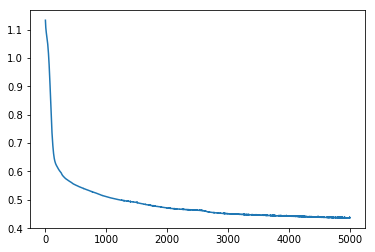

In [24]:
# import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()

## Step 3 : Evaluating and Testing

Plot historical loss from `all_losses` during network learning.

In [25]:
"""
Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every oil-well data sample (rows)
which class the network guesses (columns).

"""

confusion = torch.zeros(output_neurons, output_neurons)

Y_pred = net(X)

_, predicted = torch.max(Y_pred, 1)

# calculate accuracy
total_test = predicted.size(0)
correct_test = sum(predicted.data.numpy() == Y.data.numpy())

print('Training Accuracy: %.2f %%' % (100 * correct_test / total_test))


for i in range(train_data.shape[0]):
    actual_class = Y.data[i]
    predicted_class = predicted.data[i]

    confusion[actual_class][predicted_class] += 1

print('')
print('Confusion matrix for training:')
print(confusion)


Training Accuracy: 77.78 %

Confusion matrix for training:
tensor([[72.,  5.,  3.],
        [ 4., 60., 14.],
        [ 5., 19., 43.]])


In [26]:
"""
Step 3: Test the neural network

Pass testing data to the built neural network and get its performance
"""

# create Tensors to hold inputs and outputs
X_test = torch.Tensor(test_input.values).float()
Y_test = torch.Tensor(test_target.values).long()

# test the neural network using testing data
# It is actually performing a forward pass computation of predicted y
# by passing x to the model.
# Here, Y_pred_test contains three columns, where the index of the
# max column indicates the class of the instance
Y_pred_test = net(X_test)

# get prediction
# convert three-column predicted Y values to one column for comparison
_, predicted_test = torch.max(Y_pred_test, 1)

# calculate accuracy
total_test = predicted_test.size(0)
correct_test = sum(predicted_test.data.numpy() == Y_test.data.numpy())

print('Testing Accuracy: %.2f %%' % (100 * correct_test / total_test))

"""
Evaluating the Results

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every oil-well sample (rows)
which class the network guesses (columns).

"""

confusion_test = torch.zeros(output_neurons, output_neurons)

for i in range(test_data.shape[0]):
    actual_class = Y_test.data[i]
    predicted_class = predicted_test.data[i]

    confusion_test[actual_class][predicted_class] += 1

print('')
print('Confusion matrix for testing:')
print(confusion_test)


Testing Accuracy: 68.97 %

Confusion matrix for testing:
tensor([[23.,  0.,  1.],
        [ 2., 15.,  9.],
        [ 8.,  7., 22.]])
